In [1]:
# Reimport necessary libraries and define the required functions and setup again
import pandas as pd
import random
from datetime import datetime, timedelta

# Configuration parameters based on instructions
sta6a_values = [123, 54321, 32999, 41444]
rooms = list(range(1, 11))
trial_arms = [1, 2]
start_date = datetime(2024, 12, 1, 0, 0, 0)
num_cycles = 336  # 28 days × 12 cycles/day
leave_prob = 0.1

# Updated variance reduction factor for random walks
variance_reduction = 0.5

# Generate realistic names
first_names = ["John", "Jane", "Alice", "Bob", "Charlie", "Diana"]
last_names = ["Smith", "Johnson", "Williams", "Brown", "Jones", "Miller"]

# Helper functions
def generate_proportions():
    """Generate proportions with specified constraints."""
    vals = sorted([random.uniform(0, 1) for _ in range(3)], reverse=True)
    scale = random.uniform(0.75, 1) / sum(vals)
    return [round(val * scale, 4) for val in vals]

def assign_class(score, thresholds):
    """Assign class based on score thresholds."""
    if score <= thresholds[0]:
        return 1
    elif score <= thresholds[1]:
        return 2
    else:
        return 3

# Initialize data structures
patients = {}
simulation_data = []

# Initial setup
for sta6a in sta6a_values:
    num_patients = random.randint(5, 12)
    for _ in range(num_patients):
        patient_id = len(patients) + 1
        name = f"{random.choice(first_names)} {random.choice(last_names)}"
        trial_arm = random.choice(trial_arms)
        room = random.choice(rooms)
        patients[patient_id] = {
            "PatientName": name,
            "Trial_ARM": trial_arm,
            "Sta6a": sta6a,
            "room": room,
            "respiratory_score": random.uniform(0.1, 0.99),
            "septic_shock_score": random.uniform(0.1, 0.99),
            "respiratory_trend": None,
            "septic_shock_trend": None,
        }

# Generate data for each cycle with updates
current_datetime = start_date
for cycle in range(num_cycles):
    for sta6a in sta6a_values:
        # Simulate patient exits and new entries
        staying_patients = {
            pid: data
            for pid, data in patients.items()
            if data["Sta6a"] == sta6a and random.random() > leave_prob
        }
        num_new_patients = random.randint(5, 12) - len(staying_patients)
        for _ in range(max(0, num_new_patients)):
            patient_id = len(patients) + 1
            name = f"{random.choice(first_names)} {random.choice(last_names)}"
            trial_arm = random.choice(trial_arms)
            room = random.choice(rooms)
            patients[patient_id] = {
                "PatientName": name,
                "Trial_ARM": trial_arm,
                "Sta6a": sta6a,
                "room": room,
                "respiratory_score": random.uniform(0.1, 0.99),
                "septic_shock_score": random.uniform(0.1, 0.99),
                "respiratory_trend": None,
                "septic_shock_trend": None,
            }
            staying_patients[patient_id] = patients[patient_id]
        
        # Update scores and calculate trends with reduced variance
        for pid, data in staying_patients.items():
            prev_respiratory_score = data["respiratory_score"]
            prev_septic_score = data["septic_shock_score"]
            
            # Correlated score generation with reduced variance
            if random.random() < 0.33:
                respiratory_score = max(0.1, min(0.99, prev_respiratory_score + random.uniform(-0.025, 0.05)))
                septic_score = max(0.1, min(0.99, prev_septic_score + random.uniform(-0.025, 0.05)))
            elif random.random() < 0.66:
                respiratory_score = max(0.1, min(0.99, prev_respiratory_score - random.uniform(-0.025, 0.05)))
                septic_score = max(0.1, min(0.99, prev_septic_score - random.uniform(-0.025, 0.05)))
            else:
                respiratory_score = max(0.1, min(0.99, prev_respiratory_score + random.uniform(-0.025, 0.025)))
                septic_score = max(0.1, min(0.99, prev_septic_score + random.uniform(-0.025, 0.025)))
            
            respiratory_trend = (
                1 if respiratory_score > prev_respiratory_score else -1 if respiratory_score < prev_respiratory_score else 0
            )
            septic_trend = (
                1 if septic_score > prev_septic_score else -1 if septic_score < prev_septic_score else 0
            )
            
            # Update patient data
            data["respiratory_score"] = respiratory_score
            data["septic_shock_score"] = septic_score
            data["respiratory_trend"] = respiratory_trend
            data["septic_shock_trend"] = septic_trend
            
            # Generate record
            record = {
                "PatientID": pid,
                "room": data["room"],
                "Sta6a": data["Sta6a"],
                "PatientName": data["PatientName"],
                "Trial_ARM": data["Trial_ARM"],
                "prediction_datetime": current_datetime,
                "respiratory_score": respiratory_score,
                "respiratory_class": assign_class(respiratory_score, [0.33, 0.66]),
                "respiratory_trend": respiratory_trend,
                "septic_shock_score": septic_score,
                "septic_shock_class": assign_class(septic_score, [0.33, 0.66]),
                "septic_shock_trend": septic_trend,
            }
            
            # Add proportions for septic_shock_score_expl_* and respiratory_score_expl_*
            record.update(
                dict(
                    zip(
                        [
                            "septic_shock_score_expl_pos_1",
                            "septic_shock_score_expl_pos_2",
                            "septic_shock_score_expl_pos_3",
                        ],
                        generate_proportions(),
                    )
                )
            )
            record.update(
                dict(
                    zip(
                        [
                            "septic_shock_score_expl_neg_1",
                            "septic_shock_score_expl_neg_2",
                            "septic_shock_score_expl_neg_3",
                        ],
                        generate_proportions(),
                    )
                )
            )
            record.update(
                dict(
                    zip(
                        [
                            "respitory_score_expl_pos_1",
                            "respitory_score_expl_pos_2",
                            "respitory_score_expl_pos_3",
                        ],
                        generate_proportions(),
                    )
                )
            )
            record.update(
                dict(
                    zip(
                        [
                            "respitory_score_expl_neg_1",
                            "respitory_score_expl_neg_2",
                            "respitory_score_expl_neg_3",
                        ],
                        generate_proportions(),
                    )
                )
            )
            
            simulation_data.append(record)
    
    # Move to the next cycle
    current_datetime += timedelta(hours=2)

# Convert to DataFrame and display
df_simulation = pd.DataFrame(simulation_data)

In [2]:
df_simulation.columns

Index(['PatientID', 'room', 'Sta6a', 'PatientName', 'Trial_ARM',
       'prediction_datetime', 'respiratory_score', 'respiratory_class',
       'respiratory_trend', 'septic_shock_score', 'septic_shock_class',
       'septic_shock_trend', 'septic_shock_score_expl_pos_1',
       'septic_shock_score_expl_pos_2', 'septic_shock_score_expl_pos_3',
       'septic_shock_score_expl_neg_1', 'septic_shock_score_expl_neg_2',
       'septic_shock_score_expl_neg_3', 'respitory_score_expl_pos_1',
       'respitory_score_expl_pos_2', 'respitory_score_expl_pos_3',
       'respitory_score_expl_neg_1', 'respitory_score_expl_neg_2',
       'respitory_score_expl_neg_3'],
      dtype='object')

In [4]:
df_simulation.head()

,PatientID,room,Sta6a,PatientName,Trial_ARM,prediction_datetime,respiratory_score,respiratory_class,respiratory_trend,septic_shock_score,...,septic_shock_score_expl_pos_3,septic_shock_score_expl_neg_1,septic_shock_score_expl_neg_2,septic_shock_score_expl_neg_3,respitory_score_expl_pos_1,respitory_score_expl_pos_2,respitory_score_expl_pos_3,respitory_score_expl_neg_1,respitory_score_expl_neg_2,respitory_score_expl_neg_3
0,1,2,123,Charlie Miller,1,2024-12-01,0.522677,2,1,0.413185,...,0.0419,0.3565,0.3100,0.1316,0.5654,0.2752,0.0396,0.4829,0.4037,0.0668
1,2,9,123,Charlie Jones,2,2024-12-01,0.497043,2,1,0.317630,...,0.1827,0.5013,0.1968,0.0850,0.2927,0.2626,0.2426,0.3536,0.2417,0.2181
2,3,1,123,Diana Miller,2,2024-12-01,0.419392,2,1,0.732438,...,0.2667,0.4759,0.2743,0.2429,0.5065,0.3316,0.0423,0.6109,0.2855,0.0709
3,4,10,123,Charlie Brown,1,2024-12-01,0.846445,3,1,0.464409,...,0.0489,0.4016,0.3835,0.0051,0.4787,0.2860,0.0373,0.4108,0.3408,0.1924
4,34,8,123,Jane Williams,2,2024-12-01,0.867784,3,1,0.660536,...,0.1927,0.4107,0.3755,0.0936,0.3993,0.3966,0.0334,0.5347,0.2235,0.1714


In [5]:
df_simulation.query("PatientName == 'Charlie Miller'")[["PatientName", 'Sta6a']].value_counts()

PatientName     Sta6a
Charlie Miller  54321    605
                123      294
Name: count, dtype: int64

<Axes: >

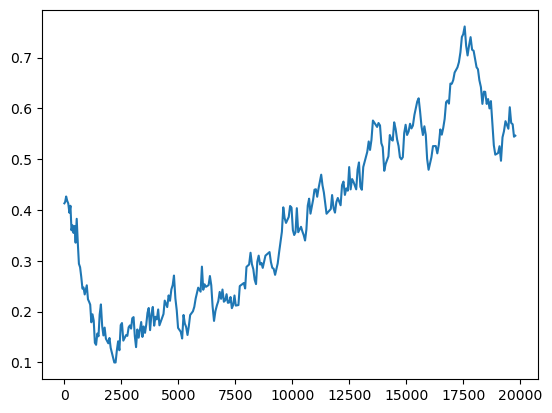

In [9]:
x = df_simulation.query("Sta6a == 123     and PatientName == 'Charlie Miller'").sort_values('prediction_datetime')
x.septic_shock_score.plot()

# Load to sqlite

In [10]:
import sqlite3

# Define the database and table name
database_name = "TeleCC.sqlite"
table_name = "patient_teleCC"

# Connect to the SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect(database_name)

# Write the DataFrame to the SQLite table
df_simulation.to_sql(table_name, conn, if_exists="replace", index=False)

# Close the connection
conn.close()

print(f"Data loaded into table '{table_name}' in database '{database_name}'.")


Data loaded into table 'patient_teleCC' in database 'TeleCC.sqlite'.


In [ ]:
pd

In [21]:
pd.options.display.max_rows = 100
pd.options.display.min_rows = 100

In [ ]:
df_simulation.groupby(["Sta6a", "prediction_datetime"]).agg("count").PatientID

In [ ]:
df_simulation.query("Sta6a == 123")[["Sta6a", "Trial_ARM", "prediction_datetime"]]

In [12]:
df_simulation.head()

,PatientID,room,Sta6a,PatientName,Trial_ARM,prediction_datetime,respiratory_score,respiratory_class,respiratory_trend,septic_shock_score,...,septic_shock_score_expl_pos_3,septic_shock_score_expl_neg_1,septic_shock_score_expl_neg_2,septic_shock_score_expl_neg_3,respitory_score_expl_pos_1,respitory_score_expl_pos_2,respitory_score_expl_pos_3,respitory_score_expl_neg_1,respitory_score_expl_neg_2,respitory_score_expl_neg_3
0,1,2,123,Charlie Miller,1,2024-12-01,0.522677,2,1,0.413185,...,0.0419,0.3565,0.3100,0.1316,0.5654,0.2752,0.0396,0.4829,0.4037,0.0668
1,2,9,123,Charlie Jones,2,2024-12-01,0.497043,2,1,0.317630,...,0.1827,0.5013,0.1968,0.0850,0.2927,0.2626,0.2426,0.3536,0.2417,0.2181
2,3,1,123,Diana Miller,2,2024-12-01,0.419392,2,1,0.732438,...,0.2667,0.4759,0.2743,0.2429,0.5065,0.3316,0.0423,0.6109,0.2855,0.0709
3,4,10,123,Charlie Brown,1,2024-12-01,0.846445,3,1,0.464409,...,0.0489,0.4016,0.3835,0.0051,0.4787,0.2860,0.0373,0.4108,0.3408,0.1924
4,34,8,123,Jane Williams,2,2024-12-01,0.867784,3,1,0.660536,...,0.1927,0.4107,0.3755,0.0936,0.3993,0.3966,0.0334,0.5347,0.2235,0.1714


# Plot histories

In [11]:
import plotly.graph_objects as go

# Filter the data for a specific patient
patient_id = 12  # Replace with the desired PatientID
patient_data = df_simulation[df_simulation["PatientID"] == patient_id]

# Create the plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=patient_data["prediction_datetime"],
        y=patient_data["septic_shock_score"],
        mode="lines+markers",
        name=f"Patient {patient_id} Septic Shock Score"
    )
)

# Define x-axis ticks and labels
tick_vals = pd.date_range(
    start=patient_data["prediction_datetime"].min(),
    end=patient_data["prediction_datetime"].max(),
    freq="2H"
)

tick_text = [
    dt.strftime("%Y-%m-%d") if dt.hour == 0 else "" for dt in tick_vals
]

# Update layout to include date labels at boundaries and ticks for 2-hour intervals
fig.update_layout(
    title=f"Historical Septic Shock Score for Patient {patient_id}",
    xaxis_title="Prediction Datetime",
    yaxis_title="Septic Shock Score",
    xaxis=dict(
        tickvals=tick_vals,      # Set tick positions
        ticktext=tick_text,      # Set tick labels (date boundary only)
        tickangle=-45,           # Rotate date labels for readability
        showgrid=True,           # Show grid lines
        dtick="M7200000",        # Maintain 2-hour intervals
    ),
    yaxis=dict(
        rangemode="tozero",  # Ensure the y-axis starts at zero
        showgrid=True,
    ),
    hovermode="x unified",  # Show a single hover label for x-axis
)

# Show the plot
fig.show()


C:\Users\GregSchwartz\AppData\Local\Temp\ipykernel_21828\1707295170.py:20: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [29]:
df_simulation.dtypes


PatientID                                 int64
room                                      int64
Sta6a                                     int64
PatientName                              object
Trial_ARM                                 int64
prediction_datetime              datetime64[ns]
respiratory_score                       float64
respiratory_class                         int64
respiratory_trend                         int64
septic_shock_score                      float64
septic_shock_class                        int64
septic_shock_trend                        int64
septic_shock_score_expl_pos_1           float64
septic_shock_score_expl_pos_2           float64
septic_shock_score_expl_pos_3           float64
septic_shock_score_expl_neg_1           float64
septic_shock_score_expl_neg_2           float64
septic_shock_score_expl_neg_3           float64
respitory_score_expl_pos_1              float64
respitory_score_expl_pos_2              float64
respitory_score_expl_pos_3              

0